# Name Generator for Dinosaurs

### @Author : HADDOU Amine

The goal of this project is to developp different neural network models to generates new dinosaur names.<br>
The objective is to developp the following two models : 
- n-grams model language
- a pre-trained model (from hugginface) finetuned to the project goal.

# Modules Import

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import os

# Discovering data

### Data Import

Importing data from `data/dinos.txt`

In [2]:
data = pd.read_csv("../data/dinos.txt", names=["dino_name"])

In [3]:
data.head()

,dino_name
0,Aachenosaurus
1,Aardonyx
2,Abdallahsaurus
3,Abelisaurus
4,Abrictosaurus


### Data Exploration

There is an overview of the imported data.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dino_name  1536 non-null   object
dtypes: object(1)
memory usage: 12.1+ KB


Exploring 20 random rows.

In [5]:
data.sample(20)

,dino_name
163,Avisaurus
948,Nqwebasaurus
1477,Xinjiangtitan
400,Dongbeititan
1361,Thecodontosaurus
954,Ohmdenosaurus
824,Magnapaulia
527,Gargoyleosaurus
1381,Tochisaurus
749,Lapampasaurus


Is there punctuation (composed names, etc) ? 

In [6]:
def print_non_alphabetical_chars(word):
    non_alphabetical = [char for char in word if char.lower() not in "abcdefghijklmnopqrstuvwxyz"]
    if non_alphabetical:
        print("Non-alphabetical characters in '{}': {}".format(word, ''.join(non_alphabetical)))
        return True
    return False

def print_non_alphabetical(data):
    presence = False # flag to check if there are any non-alphabetical characters
    for name in data["dino_name"]:
        if print_non_alphabetical_chars(name):
            presence = True
    if not presence:
        print("No non-alphabetical characters found in the dataset")

print_non_alphabetical(data)

No non-alphabetical characters found in the dataset


Does the data contains recurrent names ? If so, we should get rid of them later in the pre-processing. 

In [7]:
print("Number of duplicates in the dataset: {}".format(data.duplicated().sum()))

Number of duplicates in the dataset: 12


Let's explore words length.

In [8]:
# average length of dino names
avg_word_length = data["dino_name"].str.len().mean()

In [9]:
# max length of dino names
max_word_length = data["dino_name"].str.len().max()

In [10]:
# min length of dino names
min_word_length = data["dino_name"].str.len().min()

In [11]:
# quantile of dino names
quantile = data["dino_name"].str.len().quantile([0.25, 0.5, 0.75])

In [12]:
# number of unique dino names
unique_dino_names = data["dino_name"].nunique()

In [13]:
print(f"Average word length: {avg_word_length}")
print(f"Max word length: {max_word_length}")
print(f"Min word length: {min_word_length}")
print(f"Quantiles : {{25% : {quantile[0.25]}, 50% : {quantile[0.5]}, 75% : {quantile[0.75]}}}")

Average word length: 11.962239583333334
Max word length: 26
Min word length: 3
Quantiles : {25% : 10.0, 50% : 12.0, 75% : 13.0}


These results are interesting. Dinosaur names are, in average, very long. So, if I want to generate a name, model has to take in account enough context from previous letters to generate remaining part.

My first idea for the __n_gram model__ is to select `n_gram=3`. Because, I want to catch syllables in name. In my opinion, last syllables is enough context. It corresponds to the last 3 words before the word we want to predict.<br>
In this context, a *syllable* is defined as a sequence of three characters, usually at least the middle one is a vowel.<br>
It seems that using trigrams (3-grams) is a good choice since many words have lengths that are multiples of 3.

# Data Processing

## Lower Case Names

We should start with lower case all letters.

In [14]:
data["dino_name"] = data["dino_name"].str.lower()
data.head(2)

,dino_name
0,aachenosaurus
1,aardonyx


## Delete Recurrent values

It is time to delete previous identified dublicates.

In [15]:
data = data.drop_duplicates(subset='dino_name')
num_duplicates = data.duplicated().sum()
print(f"Number of duplicates in dino names: {num_duplicates}")

Number of duplicates in dino names: 0


## Padding

Let's add padding at the end of worlds to regularize names' length. We will try the `n-gram` model without padding.<br>
Maybe by adding a padding, the model will be able to learn __how__ dino names finish usally ("aurus", "tor", etc).

In [16]:
def add_padding(names: list[str], max_length: int) -> list[str]:
    padded_names = []
    for name in names :
        if len(name) < max_length:
            padded_names.append(name + "1" * (max_length - len(name)))
        else:
            padded_names.append(name[:max_length])
    return padded_names

In [17]:
data["paddded_dino_name"] = add_padding(data["dino_name"].values, max_word_length)

In [18]:
data.head(2)

,dino_name,paddded_dino_name
0,aachenosaurus,aachenosaurus1111111111111
1,aardonyx,aardonyx111111111111111111


## Start Token

Let's add `0` at the start and the `1` chat added during pading will be considered as an `end` token. The `0` will be usefull at the begenning of the generation to generate a first letter. For `k-gram` model, we will adjust the names by adding `k-2`*`"0"` to help model learn prediction from first letter of a name.

For the `1`, it will help us determine when the generation is finished. And it may help the model in *learning* how dino names end ("tor", "saurus",etc).. 

In [19]:
def add_start_token(names: list[str], n: int) -> list[str]:
    """Adds start '0' token at the beginning of each name."""
    return ["0" + name for name in names]

In [20]:
data["paddded_dino_name"] = add_start_token(data["paddded_dino_name"].values, max_word_length)
data.head(2)

,dino_name,paddded_dino_name
0,aachenosaurus,0aachenosaurus1111111111111
1,aardonyx,0aardonyx111111111111111111


The next function will add more `0` at the begenning of names. This will only be usefull for **n-gram** model.

In [21]:
def add_start_token_ngram(names: list[str], ngram: int) -> list[str]:
    """Adds start (n-2) '0' at the beginning of each name."""
    # (n-2) because there is already one '0' (start token) then we add the other `0` need to make a start token
    # n = 3, start toekn should be '00'. Because with "00", the model will predict the first character.
    # n = 4, start token should be '000'  
    if ngram < 2 :
        return names
    else : 
        return ["0" * (ngram-2) + name for name in names]

In [22]:
# Exemple for a 3-gram model
names = add_start_token_ngram(names = data["paddded_dino_name"].values, ngram = 3)
names[:2]

['00aachenosaurus1111111111111', '00aardonyx111111111111111111']

## Create Tokens

There is a first function to generates a list of n-grams from a list of names at a **character** level.

When building the vocabulary and tokens, we will add an `<UNK>` token that will be used for any unseen tokens or characters during generation. it is important because if the model produce a token which was not in the initial dataset, it won't be able to complete the generation.

In [23]:
def list_all_tokens(names: list[str], ngram: int) -> list[str]:
    """
    Generates and returns all unique n-grams from the names.
    
    Parameters:
        names (list[str]): List of names to extract tokens from.
        ngram (int): The size of the n-gram (e.g., 3 for trigram).
    
    Returns:
        list[str]: List of unique n-gram tokens, with <UNK> as the first token.
    """
    context_length = ngram - 1
    token_set = set()  # Use a set to store unique tokens
    
    for name in names:
        for i in range(len(name) - context_length + 1):
            token = name[i:i+context_length]
            token_set.add(token)  # Add token to set, ensuring uniqueness
    
    # Convert set to list and add <UNK> at the beginning
    return ["<UNK>"] + sorted(token_set)  # Sorting optional for consistency

In [24]:
print(list_all_tokens(["dino", "dinosour", "dinosourus"], 4))

['<UNK>', 'din', 'ino', 'nos', 'oso', 'our', 'rus', 'sou', 'uru']


For the remaing of the project, we will work with the padded data.

In [25]:
DATA = data["paddded_dino_name"]
DATA.head(2)

0    0aachenosaurus1111111111111
1    0aardonyx111111111111111111
Name: paddded_dino_name, dtype: object

# 1) N-gram model

There is some usefull functions usefull for this model __only__. Each models needs his own tool functions. Some times the difference is only a line or a word.

## Tools

After dertermining tokens of language, it is also necessary to determine our vocabulary. In our case, it is all the characters.

In [26]:
def build_vocabulary(names: list[str]) -> list[str]:
    """
    Builds and returns a list of all unique characters (vocabulary) from the names.
    
    Parameters:
        names (list[str]): List of names to extract characters from.
    
    Returns:
        list[str]: List of unique characters with <UNK> as the first item.
    """
    # Use a set for unique characters
    unique_chars = set()
    
    for name in names:
        unique_chars.update(name)  # Add all characters in the name to the set
    
    # Convert set to a sorted list and add <UNK> at the beginning
    return ["<UNK>"] + sorted(unique_chars)

Now, let's compute probability of a letter appearing after a token.

In [27]:
def print_probabilities(probabilities: np.ndarray, tokens: list[str], vocab: list[str]) -> None:
    """Prints the probabilities of generating each letter for each token."""
    for i, token in enumerate(tokens):
        print(f"Token: {token}")
        for j, letter in enumerate(vocab):
            prob = probabilities[i][j]
            if prob > 0:
                print(f"    {letter}: {prob:.3f}")

In [28]:
def compute_probabilities(names: list[str], tokens: list[str], vocab: list[str], context: int) -> np.ndarray:
    """Computes the conditional probabilities of each token generating a letter from the vocabulary."""
    probabilities_array = np.zeros((len(tokens), len(vocab)))

    # Count occurrences of letters following each token
    for name in names:
        for i in range(len(name) - context):
            token = name[i:i+context]
            next_letter = name[i+context]  # The letter after the token
            if next_letter in vocab:
                token_index = tokens.index(token) if token in tokens else tokens.index("<UNK>")
                letter_index = vocab.index(next_letter)
                probabilities_array[token_index][letter_index] += 1
            else:
                print(f"Letter {next_letter} not in vocabulary")
                probabilities_array[tokens.index("<UNK>")][vocab.index("<UNK>")] += 1

    # Normalize the probabilities by dividing by row sums
    row_sums = probabilities_array.sum(axis=1, keepdims=True)
    probabilities_array = np.divide(probabilities_array, row_sums, where=row_sums != 0, out=probabilities_array)

    # print_probabilities(probabilities_array, tokens, vocab)
    
    return probabilities_array

To add some randomness and not generating alwas the same name, we will not retrieve the most predicted letter but one of the first k letters.

In [29]:
def choose_top_k(top_k: int, probabilities: np.array, token_index: int, vocab: list[str], verbose: bool = False) -> str:
    """
    Chooses one of the top k letters based on probabilities. Only selects letters with probability > 0.
    
    Parameters:
        top_k (int): Number of top probabilities to consider.
        probabilities (np.array): 2D array of conditional probabilities (tokens x vocab).
        token_index (int): Index of the token in the probabilities array.
        vocab (list[str]): List of vocabulary characters.
        verbose (bool): If True, outputs detailed information.
    
    Returns:
        str: Chosen letter from the top k predictions.
    """
    
    # Sort the probabilities for the token and get indices in descending order
    sorted_indices = np.argsort(probabilities[token_index])[::-1]
    
    # Filter indices with probability > 0
    valid_indices = [idx for idx in sorted_indices if probabilities[token_index][idx] > 0]
    
    # Limit top_k to available valid options
    top_k = min(top_k, len(valid_indices))
    
    if top_k == 0:
        # No valid letters with probability > 0, defaulting to <UNK>
        if verbose:
            print("No valid letters with probability > 0. Falling back to <UNK>.")
        return "<UNK>"

    # Take the top_k valid indices
    best_k_indices = valid_indices[:top_k]
    
    # Display top-k letters if verbose is True
    if verbose:
        print(f"\nTop {top_k} predicted letters for token index {token_index}:")
        for idx in best_k_indices:
            print(f"Letter: {vocab[idx]}, Probability: {probabilities[token_index][idx]:.4f}")

    # Choose one of the top-k indices randomly (or the top one if k=1)
    chosen_index = np.random.choice(best_k_indices) if top_k > 1 else best_k_indices[0]
    
    chosen_letter = vocab[chosen_index]
    if verbose:
        print(f"Chosen letter: {chosen_letter}")
    
    return chosen_letter

## Model

Finally, we have all the tools to create the model.

In [30]:
def ngram_generate_name(tokens: list[str], vocab: list[str], probabilities: np.array, ngram: int, 
                        max_length: int = 10, top_k: int = 5, verbose: bool = False) -> str:
    """
    Generates a new name using an n-gram model with <UNK> token handling.
    
    Parameters:
        tokens (list[str]): List of possible n-gram tokens.
        vocab (list[str]): List of letters in the vocabulary.
        probabilities (np.array): Array of conditional probabilities for each token generating a letter.
        ngram (int): The size of the n-gram model (e.g., 3 for trigram).
        max_length (int): Maximum number of letters in the generated name.
        top_k (int): Number of top probable letters to consider at each step.
        verbose (bool): If True, prints debugging information.
    
    Returns:
        str: The generated name.
    """
    
    generated_name = ""  # Initialize with an empty string
    context_length = ngram - 1  # Number of letters to use as context
    current_token = "0" * context_length  # Start token is represented by repeated "0"
    
    if verbose:
        print(f"\nStarting name generation:")
    
    for _ in range(max_length):
        # Get the index for the current token, falling back to <UNK> if not found
        token_index = tokens.index(current_token) if current_token in tokens else tokens.index("<UNK>")
        
        if verbose:
            print(f"\nCurrent token: {current_token}")
            print(f"Name under construction: {generated_name}")
        
        # Use all possible letters at the start, otherwise limit to top_k
        # -3 to exclude <UNK>, 0 and 1 tokens
        if current_token == "0" * context_length:
            next_letter = choose_top_k(top_k=len(vocab) - 3, probabilities=probabilities, token_index=token_index, vocab=vocab, verbose=verbose)
        else:
            next_letter = choose_top_k(top_k=top_k, probabilities=probabilities, token_index=token_index, vocab=vocab, verbose=verbose)
        
        if next_letter == "1":  # End token reached
            if verbose:
                print(f"End of name reached with letter: 1\n")
            break
        
        # Append the selected letter to the generated name
        generated_name += next_letter
        # Update the token by shifting and adding the new letter
        current_token = (current_token + next_letter)[-context_length:]
    
    if verbose:
        print(f"Final generated name: {generated_name}\n")
    
    return generated_name

In [31]:
def ngram_model(names: list[str], ngram: int, num_predictions: int, max_length: int, top_k: int, verbose: bool = False) -> list[str]:
    """
    Trains an n-gram model and generates new names.
    
    Parameters:
        names (list[str]): List of input names to train the model.
        ngram (int): The size of the n-gram model (e.g., 3 for trigram).
        num_predictions (int): Number of names to generate.
        max_length (int): Maximum length of each generated name.
        top_k (int): Number of top probable letters to consider at each generation step.
        verbose (bool): If True, outputs detailed information for debugging.
    
    Returns:
        list[str]: A list of generated names.
    """
    context = ngram - 1  # Number of letters in the context (n-gram - 1)
    
    # Preprocess names by adding the right number of start tokens
    names_with_tokens = add_start_token_ngram(names=names, ngram=ngram)
    
    # Build model components
    tokens = list_all_tokens(names=names_with_tokens, ngram=ngram)
    vocab = build_vocabulary(names=names_with_tokens)
    probabilities = compute_probabilities(names=names_with_tokens, tokens=tokens, vocab=vocab, context=context)
    
    # Generate new names based on the n-gram model
    generated_names = []
    for _ in range(num_predictions):
        name = ngram_generate_name(tokens=tokens, vocab=vocab, probabilities=probabilities, ngram=ngram, max_length=max_length, top_k=top_k, verbose=verbose)
        generated_names.append(name)
    
    return generated_names

To simplify the process, there is a last function to train and print generated names in one command.

In [32]:
def train_and_generate_names(names: list[str], ngram: int, num_predictions: int, max_length: int, top_k: int, verbose: bool = False) -> list[str]:
    """
    Trains an n-gram model and prints generated names, including model parameters and 
    whether each generated name exists in the original data.
    
    Parameters:
        names (list[str]): List of input names to train the model.
        ngram (int): The size of the n-gram model (e.g., 3 for trigram).
        num_predictions (int): Number of names to generate.
        max_length (int): Maximum length of each generated name.
        top_k (int): Number of top probable letters to consider at each generation step.
        verbose (bool): If True, outputs detailed information for debugging.
    
    Returns:
        list[str]: List of generated names.
    """
    # Train the n-gram model and generate names
    generated_names = ngram_model(
        names=names,
        ngram=ngram,
        num_predictions=num_predictions,
        max_length=max_length,
        top_k=top_k,
        verbose=verbose
    )
    
    # Print the generated names with model parameters
    print(f"\nn-gram = {ngram}, top_k = {top_k}:")
    
    # Check if each generated name exists in the original data
    print("-" * 40)
    print("Generated Name | In Original Data")
    print("-" * 40)
    
    for name in generated_names:
        in_original = "True" if name in names else "False"
        print(f"{name:<15} | {in_original}")
    print("*" * 40)
    
    return generated_names

## Generate Names with n-gramm

In [33]:
# Ngram Model (n = 4), top_k = 1
train_and_generate_names(names=DATA, ngram=4, num_predictions=5, max_length=10, top_k=1, verbose=True)


Starting name generation:

Current token: 000
Name under construction: 

Top 26 predicted letters for token index 1:
Letter: a, Probability: 0.1089
Letter: s, Probability: 0.0945
Letter: p, Probability: 0.0794
Letter: c, Probability: 0.0709
Letter: t, Probability: 0.0643
Letter: m, Probability: 0.0597
Letter: l, Probability: 0.0538
Letter: d, Probability: 0.0531
Letter: b, Probability: 0.0492
Letter: e, Probability: 0.0427
Letter: h, Probability: 0.0420
Letter: g, Probability: 0.0394
Letter: n, Probability: 0.0315
Letter: o, Probability: 0.0269
Letter: r, Probability: 0.0262
Letter: k, Probability: 0.0256
Letter: j, Probability: 0.0171
Letter: z, Probability: 0.0171
Letter: y, Probability: 0.0157
Letter: i, Probability: 0.0157
Letter: f, Probability: 0.0138
Letter: v, Probability: 0.0131
Letter: u, Probability: 0.0112
Letter: w, Probability: 0.0112
Letter: x, Probability: 0.0105
Letter: q, Probability: 0.0066
Chosen letter: m

Current token: 00m
Name under construction: m

Top 1 predi

['macrocerat', 'iscus', 'anthosauru', 'lanchisaur', 'galvesauru']

There is multiple results for different models. **Scroll** (enable the option) to display all models' generated names if it is too long.  

In [34]:
# Ngram Model (n = 4), top_k = 1
_ = train_and_generate_names(names=DATA, ngram=4, num_predictions=5, max_length=10, top_k=1, verbose=False)
# Ngram Model (n = 4), top_k = 2
_ =train_and_generate_names(names=DATA, ngram=4, num_predictions=5, max_length=10, top_k=2, verbose=False)
# Ngram Model (n = 5), top_k = 2
_ =train_and_generate_names(names=DATA, ngram=5, num_predictions=5, max_length=10, top_k=2, verbose=False)
# Ngram Model (n = 3), top_k = 1
_ =train_and_generate_names(names=DATA, ngram=3, num_predictions=5, max_length=10, top_k=1, verbose=False)
# Ngram Model (n = 3), top_k = 2
_ =train_and_generate_names(names=DATA, ngram=3, num_predictions=5, max_length=10, top_k=2, verbose=False)


n-gram = 4, top_k = 1:
----------------------------------------
Generated Name | In Original Data
----------------------------------------
iscus           | False
neosaurus       | False
raptor          | False
fukuivria       | False
macrocerat      | False
****************************************

n-gram = 4, top_k = 2:
----------------------------------------
Generated Name | In Original Data
----------------------------------------
indasasaur      | False
neme            | False
paloninosp      | False
oshansauru      | False
barischusa      | False
****************************************

n-gram = 5, top_k = 2:
----------------------------------------
Generated Name | In Original Data
----------------------------------------
tanis           | False
lamacelogn      | False
baryonyx        | False
yinlongjia      | False
xuanhanosa      | False
****************************************

n-gram = 3, top_k = 1:
----------------------------------------
Generated Name | In Original Dat

Results of my generator with different parameters' values : 
-  `n = 3` and `k = 2`<br>
['neoversosuccingshadros', 'bator', 'quilmayisaurutichodosuccin', 'dasylossus', 'inosphagros']
-  `n = 3` and `k = 3`<br>
['yungonius', 'elaplossuesiohadromaia', 'venescelusothostospinax', 'xingsauros', 'euskelyx']
-  `n = 2` and `k = 3`<br>
['heisaudasilis', 'kan', 'ale', 'xiasaustesaudiangobistrops', 'raptastriong']
- `n = 4` and `k=3`<br>
['unicerosaurophale', 'yurgovuchia', 'ischyrophus', 'ovirapterovenatosaurus', 'magnapartenykus']
- `n = 4` and `k=5`<br>
['cristatus', 'vouivria', 'yongjianosaurutitanius', 'mojoceratusauravusaurornit', 'epachthosuchomimoides']

It looks like with a 4-gram model, we generate name that looks like real dino names. Even with a high randomness (k=5), results are still good.

Even with the 3-gram model, the results are good (with low randomness).

## Conclusion

The results from the n-gram models, particularly the 4-gram models, were quite promising. The generated dinosaur names were realistic and closely resembled actual dinosaur names. Notably, when using a 4-gram model with `k = 1`, the generated names were of high quality and showed a good balance between randomness and coherence.

During multiple tests, only one generated name was found in the original dataset, indicating that the model is capable of generating unique and plausible dinosaur names. This demonstrates the effectiveness of the n-gram approach in capturing the patterns and structures present in the original data.

Overall, the 4-gram model with `k = 1` proved to be the most effective configuration for generating new dinosaur names.

# 2) Deep LEarning Models

RNNs model are usually used for sequence prediction tasks. They are capable of learning long-term dependencies in data. This is the reason why they are used for text generation tasks.

## Tools

First function to implement is the victory build. Remember that our data is pre-processed in the following format :<br>
`0name1` (without necessary padding), `0name1111` (when padding is needed).

So, we can immediately move to the build vocabulary function.

In [35]:
def build_vocabulary(names: list[str]) -> dict:
    """
    Builds a vocabulary dictionary mapping each unique character to a unique integer ID,
    with "0" as the start token and "1" as the end/padding token.
    
    Parameters:
        names (list[str]): List of names to extract characters from.
    
    Returns:
        dict: A dictionary with characters as keys and integer IDs as values.
    """
    unique_chars = set("01")  # Include "0" (start) and "1" (end/padding)
    for name in names:
        unique_chars.update(name)
    
    # Assign an integer ID to each character
    vocab = {char: idx for idx, char in enumerate(sorted(unique_chars))}
    return vocab

Deep leanring model can't work with strings and chars. They need number to do all the computation and predictions. So, encoding is a must.

In [36]:
def encode_names(names: list[str], vocab: dict) -> tuple[list[list[int]], dict]:
    """
    Encodes each name as a list of integer IDs based on the vocabulary and returns a reverse vocabulary.
    
    Parameters:
        names (list[str]): List of names to encode.
        vocab (dict): Vocabulary dictionary with character-to-integer mappings.
    
    Returns:
        tuple: A tuple (encoded_names, reverse_vocab), where:
            - encoded_names is a list of encoded names, each represented as a list of integers.
            - reverse_vocab is a dictionary mapping integer IDs back to characters.
    """
    reverse_vocab = {idx: char for char, idx in vocab.items()}
    encoded_names = [[vocab[char] for char in name] for name in names]
    return encoded_names, reverse_vocab

Data is finally ready for LSTM. Now, we will create `X` and `y` sets to train the model.

To define `X` and `y`, we will re-use the previous notion of **n-gram**. Indeed, RNN will learn to predict `y` letter, based on previous $k$-characteres contained in `X`.

In [37]:
def prepare_sequence_data(encoded_names: list[list[int]], sequence_length: int) -> tuple:
    """
    Prepares the training data (X, y) for an RNN model (LSTM, GRU, etc.).
    
    Parameters:
        encoded_names (list[list[int]]): List of encoded names where each character is an integer ID.
        sequence_length (int): The fixed length of each input sequence for the model.
    
    Returns:
        tuple: A tuple (X, y) where X is an array of input sequences and y is an array of target characters as integer IDs.
    """
    X, y = [], []
    
    # For each name, create input-output pairs by sliding a window of size `sequence_length`
    for name in encoded_names:
        for i in range(len(name) - sequence_length):
            input_seq = name[i:i + sequence_length]  # List of integer IDs
            target_char = name[i + sequence_length]  # Integer ID for target character
            X.append(input_seq)
            y.append(target_char)
    
    # Ensure X and y are integer arrays
    X = np.array(X, dtype=int)
    y = np.array(y, dtype=int)
    
    return X, y

Finally, I will implement a global variable that use the *helpers* functions implemented. That's will be usefull for generating multiple data to try LSTM on different *n-gram* setup. 

In [38]:
def prepare_model_data(names: list[str], sequence_length: int) -> tuple:
    """
    Prepares all necessary components for training an RNN model to generate names.
    
    Parameters:
        names (list[str]): List of names to use for training.
        sequence_length (int): The fixed length of each input sequence for the model.
    
    Returns:
        tuple: A tuple (X, y, vocab, reverse_vocab), where:
            - X is an array of input sequences
            - y is an array of target characters as integer IDs
            - vocab is a dictionary mapping characters to integer IDs
            - reverse_vocab is a dictionary mapping integer IDs back to characters
    """
    # Step 1: Build vocabulary
    vocab = build_vocabulary(names)
    
    # Step 2: Encode names and create the reverse vocabulary
    encoded_names, reverse_vocab = encode_names(names, vocab)
    
    # Step 3: Prepare X and y for model training
    X, y = prepare_sequence_data(encoded_names, sequence_length)
    
    return X, y, vocab, reverse_vocab

## Models

Different models will be implemented. All are RNN based models but with different architecture.


### 1. Standard LSTM Model
- __Input Layer__: Accepts input sequences of length `sequence_length`.
- __Embedding Layer__: Maps each character (represented by an integer index) into a dense vector, enabling the model to capture relationships between characters.
- __LSTM Layer__: An LSTM layer learns sequential dependencies in the input data.
- __Dense Layer__: Outputs a probability distribution across possible characters, predicting the next character in the sequence.

In [39]:
def build_lstm_model(vocab_size: int, sequence_length: int, embedding_dim: int = 50, lstm_units: int = 64) -> Model :
    """
    Builds an LSTM model for name generation.
    
    Parameters:
        vocab_size (int): Size of the vocabulary.
        sequence_length (int): Length of each input sequence.
        embedding_dim (int): Dimension of the embedding layer.
        lstm_units (int): Number of LSTM units.
    
    Returns:
        Model : Compiled LSTM model.
    """
    inputs = Input(shape=(sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    lstm1 = LSTM(lstm_units, return_sequences=False)(embedding) # return_sequences=False because we only need the last output
    output = Dense(vocab_size, activation='softmax')(lstm1)

    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



### 2. LSTM Model with Dropout
- **Input Layer**: Processes sequences of length `sequence_length`.
- **Embedding Layer**: Converts each character (integer index) to a dense embedding vector, allowing the model to learn character patterns.
- **LSTM Layer with Dropout**: An LSTM layer, equipped with dropout and recurrent dropout, to improve generalization and reduce overfitting on sequence patterns. Overfitting is **not** wanted here to not have a model that generates exact names from data.
- **Dropout Layer**: Adds an additional dropout layer after the LSTM layer to further improve regularization.
- **Dense Layer**: Outputs a probability distribution to predict the next character in the sequence.

In [40]:
def build_lstm_dropIn_model(vocab_size: int, sequence_length: int, embedding_dim: int = 50, lstm_units: int = 64) -> Model:
    """
    Builds an LSTM model for name generation with dropout for regularization.
    
    Parameters:
        vocab_size (int): Size of the vocabulary.
        sequence_length (int): Length of each input sequence.
        embedding_dim (int): Dimension of the embedding layer.
        lstm_units (int): Number of LSTM units.
    
    Returns:
        Model: Compiled LSTM model.
    """
    inputs = Input(shape=(sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    # First LSTM layer with dropout in the LSTM and after it
    lstm1 = LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(embedding)
    dropout1 = Dropout(0.2)(lstm1)
    
    # Output layer
    output = Dense(vocab_size, activation='softmax')(dropout1)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 3. GRU Model for Name Generation

- **Source**: Adapted from [Using RNN Model for Text Generation](https://medium.com/analytics-vidhya/using-rnn-model-for-text-generation-c5a37017d142) on Medium.
  
- **Input Layer**: Accepts input sequences of length `sequence_length`, each integer representing a character.
- **Embedding Layer**: Maps each character index into a 200-dimensional vector, allowing the model to learn relationships between characters.
- **GRU Layers with Batch Normalization and Dropout**:
  - **First GRU Layer**: Contains 64 units with batch normalization and dropout, returning sequences to pass to the next layer.
  - **Second GRU Layer**: Contains 128 units, also with batch normalization and dropout, capturing more complex patterns.
  - **Third GRU Layer**: Contains 256 units, with batch normalization and dropout, outputting a single vector for the final dense layers.
- **Dense Layer with ReLU**: Fully connected layer with 200 units, ReLU activation, and L2 regularization to add non-linearity.
- **Output Layer**: A softmax layer that produces a probability distribution over `vocab_size` characters, allowing the model to predict the next character in the sequence.

This configuration enables the model to learn sequential dependencies and generate names by predicting one character at a time.

In [41]:
def build_gru_model(vocab_size: int, sequence_length: int, embedding_size : int) -> Model:
    """
    Builds a GRU-based model for name generation using the Keras functional API.
    
    Parameters:
        vocab_size (int): Size of the vocabulary.
        sequence_length (int): Length of each input sequence.
    
    Returns:
        Model: Compiled GRU model.
    """
    # Input layer
    inputs = Input(shape=(sequence_length,))
    
    # Embedding layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size)(inputs)
    
    # First GRU layer with Batch Normalization and Dropout
    gru1 = GRU(64, return_sequences=True)(embedding)
    bn1 = BatchNormalization()(gru1)
    dropout1 = Dropout(0.2)(bn1)
    
    # Second GRU layer with Batch Normalization and Dropout
    gru2 = GRU(128, return_sequences=True)(dropout1)
    bn2 = BatchNormalization()(gru2)
    dropout2 = Dropout(0.2)(bn2)
    
    # Third GRU layer with Batch Normalization and Dropout
    gru3 = GRU(256, return_sequences=False)(dropout2)
    bn3 = BatchNormalization()(gru3)
    dropout3 = Dropout(0.2)(bn3)
    
    # Dense layer with ReLU activation and L2 regularization
    dense = Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout3)
    bn4 = BatchNormalization()(dense)
    dropout4 = Dropout(0.2)(bn4)
    
    # Output layer with Softmax activation
    outputs = Dense(vocab_size, activation='softmax')(dropout4)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Initiallization of Models

In [42]:
DATA = data["paddded_dino_name"]
sequence_length = 3
embedding_size = max_word_length
X, y, vocab, reverse_vocab = prepare_model_data(names=DATA, sequence_length=sequence_length)
vocab_size = len(vocab)

X.shape, y.shape, vocab_size, sequence_length

((36576, 3), (36576,), 28, 3)

In [43]:
lstm_model = build_lstm_model(vocab_size=vocab_size, sequence_length=sequence_length, embedding_dim=embedding_size, lstm_units=64)

In [44]:
lstm_dropout = build_lstm_dropIn_model(vocab_size=vocab_size, sequence_length=sequence_length, embedding_dim=embedding_size, lstm_units=64)

In [45]:
gru_model = build_gru_model(vocab_size=vocab_size, sequence_length=sequence_length, embedding_size=embedding_size)

## Training

Function to simply training new models.

In [46]:
def training(name: str, model: Model, X: np.array, y: np.array, batch_size: int, epochs: int) -> tuple:
    """
    Trains the given model on the input data.
    
    Parameters:
        name (str): Name of the model.
        model (Model): Keras model to train.
        X (np.array): Input data for training.
        y (np.array): Target data for training.
        batch_size (int): Number of samples per batch.
        epochs (int): Number of epochs to train.
    
    Returns:
        tuple: Trained Keras model and training history.
    """
    print(f"Training {name} model...")
    early_stopping = EarlyStopping(patience=10)
    
    # Train the model with validation split and early stopping
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, 
                        callbacks=[early_stopping], verbose=1)
    
    return model, history

In [47]:
lstm_model, lstm_history = training("LSTM", lstm_model, X, y, batch_size=64, epochs=50)

Training LSTM model...
Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5840 - loss: 1.6962 - val_accuracy: 0.7079 - val_loss: 1.0533
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7165 - loss: 1.0111 - val_accuracy: 0.7288 - val_loss: 0.9254
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7462 - loss: 0.8695 - val_accuracy: 0.7444 - val_loss: 0.8692
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7541 - loss: 0.8398 - val_accuracy: 0.7562 - val_loss: 0.8296
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7619 - loss: 0.8047 - val_accuracy: 0.7574 - val_loss: 0.8081
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7717 - loss: 0.7735 - val_accuracy: 0.7695 - val_loss: 0.7927
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7778 - loss: 0.7657 - val_accuracy: 0.7758 - val_loss: 0.7771
Epoch 8/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7819 - loss: 0.

In [48]:
lstm_dropout, lstm_dropout_history = training("LSTM with Dropout", lstm_dropout, X, y, batch_size=64, epochs=50)

Training LSTM with Dropout model...
Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5843 - loss: 1.7366 - val_accuracy: 0.6899 - val_loss: 1.0740
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7095 - loss: 1.0245 - val_accuracy: 0.7317 - val_loss: 0.9287
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7361 - loss: 0.9204 - val_accuracy: 0.7351 - val_loss: 0.8844
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7486 - loss: 0.8646 - val_accuracy: 0.7419 - val_loss: 0.8516
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7416 - loss: 0.8725 - val_accuracy: 0.7499 - val_loss: 0.8284
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7591 - loss: 0.8194 - val_accuracy: 0.7594 - val_loss: 0.8077
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7619 - loss: 0.8141 - val_accuracy: 0.7624 - val_loss: 0.7940
Epoch 8/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.76

In [49]:
gru_model, gru_history = training("GRU", gru_model, X, y, batch_size=64, epochs=50)

Training GRU model...
Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6692 - loss: 2.8885 - val_accuracy: 0.7176 - val_loss: 1.4665
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7502 - loss: 1.0774 - val_accuracy: 0.7597 - val_loss: 0.9079
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7595 - loss: 0.9393 - val_accuracy: 0.7783 - val_loss: 0.8760
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7683 - loss: 0.8940 - val_accuracy: 0.7750 - val_loss: 0.8569
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7756 - loss: 0.8589 - val_accuracy: 0.7858 - val_loss: 0.8464
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7791 - loss: 0.8541 - val_accuracy: 0.7873 - val_loss: 0.8285
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7832 - loss: 0.8267 - val_accuracy: 0.7888 - val_loss: 0.8279
Epoch 8/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7902 - 

## Evaluation

It is hard to evaluate and compare different models in this type of problem. We want to overfitt to generate name that looks like dino names. But in the same time, we would like to not overfitt to much in order to generate new names.

I propose to see how models learnt (overfitting ? generalization ?) 

In [50]:
def plot_loss_comparison(histories, model_names):
    """
    Plots training and validation loss for multiple models on the same graph, with different line styles.
    
    Parameters:
        histories (list): List of history objects from training different models.
        model_names (list): List of model names corresponding to each history object.
    """
    plt.figure(figsize=(10, 6))
    
    # Define line styles for each model
    line_styles = ['-', '--', '-.', ':']  # Cycle through these styles for distinction
    
    for i, (history, model_name) in enumerate(zip(histories, model_names)):
        style = line_styles[i % len(line_styles)]  # Cycle through line styles
        
        # Plot training and validation loss with distinct styles
        plt.plot(history.history['loss'], linestyle=style, label=f'{model_name} Training Loss')
        plt.plot(history.history['val_loss'], linestyle=style, label=f'{model_name} Validation Loss', alpha=0.7)
    
    plt.title('Training and Validation Loss for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

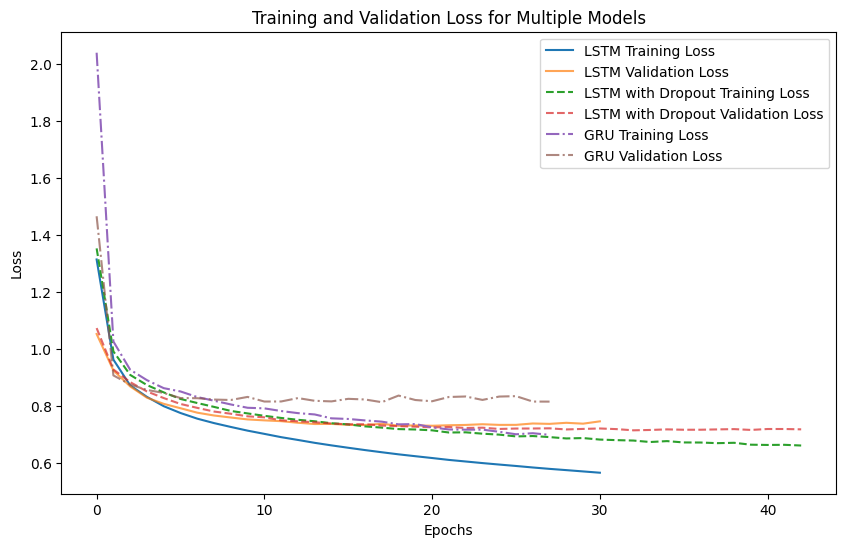

In [51]:
plot_loss_comparison(histories=[lstm_history, lstm_dropout_history, gru_history],
                        model_names=["LSTM", "LSTM with Dropout", "GRU"])

It appears that the **LSTM** model learns quickly, achieving a lower training loss over time compared to the other models. Based on its validation loss curve, the model seems to generalize more or less well (but maybe is enough for our case ?), as the validation loss does not diverge significantly from the training loss. However, the direction of training and validation loss curves suggests mild underfitting, meaning the model might still benefit from additional capacity or a longer training duration to capture more complex patterns.

The **LSTM with Dropout** model learns at a similar rate initially but stabilizes earlier than the standard LSTM. Its validation loss is close to the training loss, indicating better generalization and reduced overfitting, which is expected due to dropout regularization. However, this stability comes at the cost of a slightly higher error than the standard LSTM model. Is a high generalization what we need in this study case ? We will see it later.

Finally, **GRU** shows decent performance, similar to the LSTM with Dropout in terms of generalization. Its training and validation loss curves are also close, which indicates good generalization and stability. However, like the LSTM with Dropout, it seems to converge to a slightly higher loss than the standard LSTM.

## Name Generation Tools (Deeplearning version)

This function is the equivalent of `choose_top_k` implemented for `n_gram` model.

In [52]:
def sample_from_top_k(predictions, k):
    """
    Samples an index from the top k predictions, weighted by probabilities.
    
    Parameters:
        predictions (np.array): Array of probabilities for the next character.
        k (int): Number of top predictions to consider.
    
    Returns:
        int: The index of the chosen character.
    """
    # Sort the probabilities and get the top k indices
    top_k_indices = np.argsort(predictions)[-k:]
    top_k_probs = predictions[top_k_indices]
    
    # Normalize probabilities to sum to 1
    top_k_probs = top_k_probs / np.sum(top_k_probs)
    
    # Sample from the top k indices based on their probabilities
    chosen_index = np.random.choice(top_k_indices, p=top_k_probs)
    
    return chosen_index

Like it was done before, there is a function to generate one name with one of the implemented model. 

In [53]:
def generate_name(model, vocab: dict, reverse_vocab: dict, max_length: int, sequence_length: int, top_k: int) -> str:
    """
    Generates a new name using the trained model, starting with the <0> token, with added randomness through top_k sampling.
    
    Parameters:
        model (Model): Trained Keras model for name generation.
        vocab (dict): Dictionary mapping characters to integer IDs.
        reverse_vocab (dict): Dictionary mapping integer IDs back to characters.
        max_length (int): Maximum length of the generated name.
        sequence_length (int): Length of each input sequence for the model.
        top_k (int): Number of top probable characters to sample from.
    
    Returns:
        str: Generated name.
    """
    # Start with the <0> token repeated to form the initial sequence
    start_token = [vocab["0"]] * sequence_length
    name = []

    for _ in range(max_length):
        input_seq = np.array([start_token])  # Shape (1, sequence_length)
        predictions = model.predict(input_seq, verbose=0)[0]  # Predict next character probabilities
        
        # Sample the next character index from the top k probable choices
        next_char_index = sample_from_top_k(predictions, top_k)
        next_char = reverse_vocab[next_char_index]
        
        # Stop if the end token <1> is generated
        if next_char == "1":
            break
        
        # Append the predicted character to the name
        name.append(next_char)
        
        # Update the input sequence by shifting and adding the new character
        start_token = start_token[1:] + [next_char_index]

    # Join the list of characters to form the generated name
    return ''.join(name)

For testing purpose, another function to generate multiple names at one will be implemented.

In [54]:
def generate_multiple_names(model, vocab: dict, reverse_vocab: dict, num_names: int, max_length: int, sequence_length: int, top_k: int) -> list:
    """
    Generates multiple names using the trained model, each starting with the <0> token and using top_k sampling.
    
    Parameters:
        model (Model): Trained Keras model for name generation.
        vocab (dict): Dictionary mapping characters to integer IDs.
        reverse_vocab (dict): Dictionary mapping integer IDs back to characters.
        num_names (int): Number of names to generate.
        max_length (int): Maximum length of each generated name.
        sequence_length (int): Length of each input sequence for the model.
        top_k (int): Number of top probable characters to sample from.
    
    Returns:
        list: A list of generated names.
    """
    names = []
    
    for _ in range(num_names):
        name = generate_name(model=model, vocab=vocab, reverse_vocab=reverse_vocab, max_length=max_length, sequence_length=sequence_length, top_k=top_k)
        names.append(name)
    
    return names

## Generation of Dino Names

k (one of k most probable letters) = 1

In [55]:
# Generate 10 names from each model
num_names = 10

lstm_names = generate_multiple_names(model=lstm_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length, top_k=1)
lstm_dropout_names = generate_multiple_names(model=lstm_dropout, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=1)
gru_names = generate_multiple_names(model=gru_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=1)

# Print the generated names
print("Generated LSTM Names:", lstm_names)
print("Generated LSTM with Dropout Names:", lstm_dropout_names)
print("Generated GRU Names:", gru_names)

Generated LSTM Names: ['raptor', 'raptor', 'raptor', 'raptor', 'raptor', 'raptor', 'raptor', 'raptor', 'raptor', 'raptor']
Generated LSTM with Dropout Names: ['uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus', 'uanosaurus']
Generated GRU Names: ['nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus', 'nchisaurus']


k = 2

In [56]:
# Generate 10 names from each model
num_names = 10

lstm_names = generate_multiple_names(model=lstm_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length, top_k=2)
lstm_dropout_names = generate_multiple_names(model=lstm_dropout, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=2)
gru_names = generate_multiple_names(model=gru_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=2)

# Print the generated names
print("Generated LSTM Names:", lstm_names)
print("Generated LSTM with Dropout Names:", lstm_dropout_names)
print("Generated GRU Names:", gru_names)

Generated LSTM Names: ['raptor', 'ryodon', 'ryphosaurus', 'trosaurus', 'raptor', 'raptoraptor', 'ryphus', 'rahale', 'raptor', 'ryptor']
Generated LSTM with Dropout Names: ['inosaurus', 'ulasaurus', 'ulanosaurus', 'inosaurus', 'iaraptor', 'inganosaurus', 'iangosaurus', 'uanosaurus', 'uanosaurus', 'ianganosaurus']
Generated GRU Names: ['rchaeosaura', 'rgong', 'ndosaurus', 'ncondylus', 'ncheirus', 'ndromerus', 'nchenius', 'rgongosaurus', 'rgosaurus', 'ndosauraptor']


k = 5

In [57]:
# Generate 10 names from each model
num_names = 10

lstm_names = generate_multiple_names(model=lstm_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length, top_k=5)
lstm_dropout_names = generate_multiple_names(model=lstm_dropout, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=5)
gru_names = generate_multiple_names(model=gru_model, vocab=vocab, reverse_vocab=reverse_vocab, num_names=num_names, max_length=max_word_length, sequence_length=sequence_length,top_k=5)

# Print the generated names
print("Generated LSTM Names:", lstm_names)
print("Generated LSTM with Dropout Names:", lstm_dropout_names)
print("Generated GRU Names:", gru_names)

Generated LSTM Names: ['ropelta', 'nichasaurus', 'ratothodesteondypsaurus', 'nedmoresaurus', 'ititan', 'iriasaurus', 'rahoes', 'ryosaurasaurus', 'bias', 'tamosaurus']
Generated LSTM with Dropout Names: ['errus', 'indoraptor', 'ungshiceratitangosaurus', 'uanshanosaurus', 'unasaurus', 'iravur', 'ulicondrachinosaurus', 'yplus', 'yplosaurus', 'uangatops']
Generated GRU Names: ['criscapauceratus', 'rator', 'ntiragosaurus', 'lomomaeus', 'nocerator', 'rchanosaurus', 'nchistoceratops', 'rcisaurus', 'ratops', 'rguraptor']


# Credits
ChatGPT : For giving advice, logs and commenting my code. <br>
Copilot : Auto-completion. Sometime, it auto-completed functions. *Note* : Functions were then modified to adapt my context, my vision or my logic.<br> 
Medium : [Using RNN Model For Text Generation](https://medium.com/analytics-vidhya/using-rnn-model-for-text-generation-c5a37017d142)<br>
Professor Riveilli courses<br>
Medium : [Generation de texte par n-gram](https://beranger.medium.com/nlp-g%C3%A9n%C3%A9ration-de-texte-par-n-grams-3894187f6cd4). Not the code this time but the idea and path to implement the model.